<a href="https://colab.research.google.com/github/tylee33/Vision_Lecture/blob/main/%5B3week%5D2_GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import matplotlib
matplotlib.use("Agg")
%matplotlib inline
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
from keras.datasets import cifar10
import numpy as np

## Convolutional Module Implementation
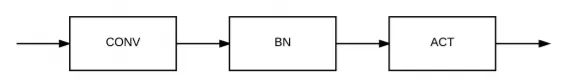

### We construct the ‘conv_module’ which is a series of convolutional and a batch normalization layer that is ultimately passed through a Relu activation.

In [ ]:
def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim,padding="same"):
  input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
  input = BatchNormalization(axis=chanDim)(input)
  input = Activation("relu")(input)
  return input

##Arguments:

### 1. Input: Input to be processed
### 2. No of filters: No of filters that should be in the Conv2D layer.
### 3. FilterX and FilterY: Size of the filters.
### 4. Stride
### 5. Channel dimension
### 6. Padding: Predefined to ‘same’ for the whole model.

## Inception Module Implementation
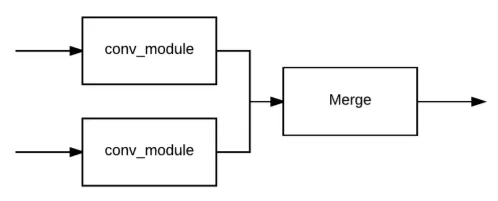
### We define our modified inception module by using two conv_modules. The first module is initialized with:

### 1.1×1 filters(used to learn local features in images).
### 2.The second and third with 3×3 and 5×5 respectively(responsible for learning general features).
### 3.Define the pool projection layer using a global pooling layer.
### 4.After that, we concatenate the layer outputs along the channel dimension(chanDim).

In [ ]:
def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim):
                                 #Step 1
  conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
                                 #Step 2
  conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
  conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
                                 #Step 3
  pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
  pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
                                 #Step 4
  input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
  return input

## Downsample Module Implementation
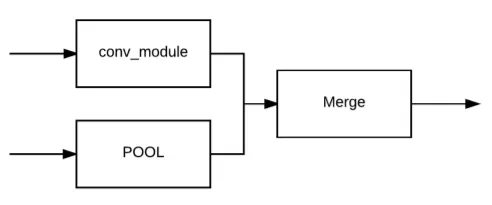
### As we could see in the architecture which is supposed to be built above the model is very deep. Thus it requires downsampling so that the no of trainable parameters can be controlled. For that function, we use a downsample_module. It is basically the concatenation of the output of a max-pooling layer and a conv_module(with 3×3 filters).

In [ ]:
def downsample_module(input,No_of_filters,chanDim):
  conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
  pool = MaxPooling2D((3,3),strides=(2,2))(input)
  input = concatenate([conv_3x3,pool],axis=chanDim)
  return input

## Model Implementation
### 1.Define an input layer with the width, height, and depth parameters of the function.
### 2.Use two inception modules along with a downsampling module.
### 3.Use Five inception modules along with a downsampling module.
### 4.Use two inception modules with pooling and dropout.
### 5.Flatten layer, with a dense layer(with no of units equal to no of classes) along with an activation layer with softmax classifier.

In [ ]:
def MiniGoogleNet(width,height,depth,classes):
  inputShape=(height,width,depth)
  chanDim=-1

  # (Step 1) Define the model input
  inputs = Input(shape=inputShape)

  # First CONV module
  x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)

  # (Step 2) Two Inception modules followed by a downsample module
  x = inception_module(x, 32, 32,32,32,chanDim)
  x = inception_module(x, 32, 48, 48,32,chanDim)
  x = downsample_module(x, 80, chanDim)
  
  # (Step 3) Five Inception modules followed by a downsample module
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = inception_module(x, 96, 64, 32,32,chanDim)
  x = inception_module(x, 80, 80, 32,32,chanDim)
  x = inception_module(x, 48, 96, 32,32,chanDim)
  x = inception_module(x, 112, 48, 32, 48,chanDim)
  x = downsample_module(x, 96, chanDim)

  # (Step 4) Two Inception modules followed
  x = inception_module(x, 176, 160,96,96, chanDim)
  x = inception_module(x, 176, 160, 96,96,chanDim)
  
  # Global POOL and dropout
  x = AveragePooling2D((7, 7))(x)
  x = Dropout(0.5)(x)

  # (Step 5) Softmax classifier
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation("softmax")(x)

  # Create the model
  model = Model(inputs, x, name="googlenet")
  return model

## Decay Parameter
### Initialize the number of epochs and the initial learning rate. Next, create a polynomial decay function that will compute a dynamic learning rate. It will change/decay with every epoch in a polynomial manner.



In [ ]:
NUM_EPOCHS = 50
INIT_LR = 5e-3
def poly_decay(epoch):
  maxEpochs = NUM_EPOCHS
  baseLR = INIT_LR
  power = 1.0
  alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
  return alpha

## Preparing the Data
### Load the CIFAR dataset as arrays in the float data type.

### 1.Compute the mean of each train and test dataset and subtract it. So that the pixel values are normalized.
### 2.Use the label binarizer to convert the labels from integers to vectors.
### 3.Use the image data generator to create variation in data.

In [ ]:
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")
                                # Step 1
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean
                                # Step 2
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
                                # Step 3
aug = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1, horizontal_flip=True,fill_mode="nearest")

170508288/170498071 [==============================] - 2s 0us/step


## Compiling and Fitting the Model
### Define the callbacks and optimizers for the model. Create a model instance with arguments of width, height, depth, and classes(32,32,3,10).

### 1.Compile the model with categorical cross-entropy loss and set the metric to accuracy.
### 2.Fit the model with the data generator, validation data, steps per epoch, no of epochs, and callbacks.

In [ ]:
callbacks=[LearningRateScheduler(poly_decay)]
opt = SGD(lr=INIT_LR, momentum=0.9)
model = MiniGoogleNet(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.fit(aug.flow(trainX, trainY, batch_size=64),validation_data=(testX, testY), steps_per_epoch=len(trainX) // 64,epochs=NUM_EPOCHS, callbacks=callbacks, verbose=1)

Epoch 1/50
280/781 [=========>....................] - ETA: 1:46:58 - loss: 1.6718 - accuracy: 0.3879

## Evaluating the Model
### Use the below code to checks the test accuracy. It comes out to be approximately 90 percent. (Top 20 for the CIFAR-10 dataset on kaggle)

In [ ]:
score=model.evaluate(testX,testY)
print('Test Score=',score[0])
print('Test Accuracy=',score[1])